## Problem Description

#### Context:
Traditionally, the design of a cellular network focuses on the optimization of energy and resources that guarantees a smooth operation even during peak hours (i.e. periods with higher traffic load). However, this implies that cells are most of the time overprovisioned of radio resources. Next generation cellular networks ask for a dynamic management and configuration in order to adapt to the varying user demands in the most efficient way with regards to energy savings and utilization of frequency resources. If the network operator were capable of anticipating to those variations in the users’ traffic demands, a more efficient management of the scarce (and expensive) network resources would be possible.
Current research in mobile networks looks upon Machine Learning (ML) techniques to help manage those resources. In this case, you will explore the possibilities of ML to detect abnormal behaviors in the utilization of the network that would motivate a change in the configuration of the base station.

#### Goal:
The objective of the network optimization team is to analyze traces of past activity, which will be used to train an ML system capable of classifying samples of current activity as:
• 0 (normal): current activity corresponds to normal behavior of any working day and. Therefore, no re-configuration or redistribution of resources is needed.
• 1 (unusual): current activity slightly differs from the behavior usually observed for that time of the day (e.g. due to a strike, demonstration, sports event, etc.), which should trigger a reconfiguration of the base station.

## Data Collection



#### Content:
The dataset has been obtained from a real LTE deployment. During two weeks, different metrics were gathered from a set of 10 base stations, each having a different number of cells, every 15 minutes. The dataset is provided in the form of a csv file, where each row corresponds to a sample obtained from one particular cell at a certain time. Each data example contains the following features:

* Time : hour of the day (in the format hh:mm) when the sample was generated.
* CellName1: text string used to uniquely identify the cell that generated the current sample. CellName is in the form xαLTE, where x identifies the base station, and α the cell within that base station.
*  PRBUsageUL and PRBUsageDL: level of resource utilization in that cell measured as the portion of Physical Radio Blocks (PRB) that were in use (%) in the previous 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* meanThrDL and meanThrUL: average carried traffic (in Mbps) during the past 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* maxThrDL and maxThrUL: maximum carried traffic (in Mbps) measured in the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* meanUEDL and meanUEUL: average number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* maxUEDL and maxUEUL: maximum number of user equipment (UE) devices that were simultaneously active during the last 15 minutes. Uplink (UL) and downlink (DL) are measured separately.
* maxUE_UL+DL: maximum number of user equipment (UE) devices that were active simultaneously in the last 15 minutes, regardless of UL and DL.

* Unusual: labels for supervised learning. A value of 0 determines that the sample corresponds to normal operation, a value of 1 identifies unusual behavior.

The dataset is from [Kagge](https://www.kaggle.com/competitions/anomaly-detection-in-cellular-networks/overview)

## Expository Data Analysis

In [1]:
## Import the neccessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Read the data
train = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/DSML-Projects/main/FraudDetection/ML-MATT-CompetitionQT1920_train.csv',
                    encoding='windows-1252')
test = pd.read_csv('https://raw.githubusercontent.com/chimaobi-okite/DSML-Projects/main/FraudDetection/ML-MATT-CompetitionQT1920_test.csv',
                   encoding='windows-1252')

In [3]:
train.head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
0,10:45,3BLTE,11.642,1.393,0.370,0.041,15.655,0.644,1.114,1.025,4.0,3.0,7,1
1,9:45,1BLTE,21.791,1.891,0.537,0.268,10.273,1.154,1.353,1.085,6.0,4.0,10,1
2,7:45,9BLTE,0.498,0.398,0.015,0.010,0.262,0.164,0.995,0.995,1.0,1.0,2,1
3,2:45,4ALTE,1.891,1.095,0.940,0.024,60.715,0.825,1.035,0.995,2.0,2.0,4,1
4,3:30,10BLTE,0.303,0.404,0.016,0.013,0.348,0.168,1.011,1.011,2.0,1.0,3,0


In [4]:
# create a copy of the train data for analysis
data = train.copy()

In [5]:
print('The shape of the train data is {}'.format(data.shape))

The shape of the train data is (36904, 14)


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36904 entries, 0 to 36903
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         36904 non-null  object 
 1   CellName     36904 non-null  object 
 2   PRBUsageUL   36904 non-null  float64
 3   PRBUsageDL   36904 non-null  float64
 4   meanThr_DL   36904 non-null  float64
 5   meanThr_UL   36904 non-null  float64
 6   maxThr_DL    36904 non-null  float64
 7   maxThr_UL    36904 non-null  float64
 8   meanUE_DL    36904 non-null  float64
 9   meanUE_UL    36904 non-null  float64
 10  maxUE_DL     36815 non-null  float64
 11  maxUE_UL     36815 non-null  float64
 12  maxUE_UL+DL  36899 non-null  object 
 13  Unusual      36904 non-null  int64  
dtypes: float64(10), int64(1), object(3)
memory usage: 3.9+ MB


### Missing values Check

create a function that checks for columns with missing values and plot them in a graph

In [7]:
def check_missing(data):
  size = data.shape[0]
  missing = data.isnull().sum()[data.isnull().sum() > 0].sort_values()
  if not missing.empty :
    plot_missing(missing, size)
  else:
    print('This dataframe has no missing values')

def plot_missing(data : pd.Series, size):
  plt.style.use('seaborn-darkgrid')
  plt.title('Missing Values Plot')
  ax = data.plot.barh(color = 'green')

  for p in ax.patches:
    percentage ='{:,.2f}%'.format((p.get_width()/size)*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

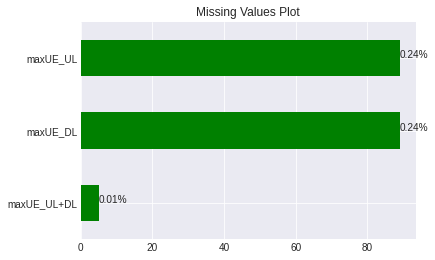

In [8]:
check_missing(data)

In [9]:
## see what the data looks like where maxUE_UL is null
## This is to gain insights on how to impute this values
data[data['maxUE_UL'].isnull()].head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
51,16:15,6ALTE,13.743,4.042,2.113,0.100,44.483,1.110,0.0,0.0,NaN,NaN,#¡VALOR!,0
1290,14:30,3BLTE,22.837,2.324,0.500,0.090,24.374,0.847,0.0,0.0,NaN,NaN,#¡VALOR!,0
2082,6:15,7ULTE,0.199,1.791,0.693,0.032,15.634,0.353,0.0,0.0,NaN,NaN,#¡VALOR!,1
2842,16:15,5ALTE,9.903,1.516,0.466,0.032,24.576,0.931,0.0,0.0,NaN,NaN,#¡VALOR!,0
3384,16:15,7CLTE,0.404,0.909,0.216,0.042,9.730,2.714,0.0,0.0,NaN,NaN,#¡VALOR!,0


In [10]:
data[data['maxUE_UL+DL'] == '0'].head()

,Time,CellName,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,maxUE_UL+DL,Unusual
74,4:45,2ALTE,0.0,0.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
479,4:45,2ALTE,0.0,0.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
937,5:00,2ALTE,0.0,0.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1361,3:00,2ALTE,0.0,0.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1906,6:30,2ALTE,0.0,0.404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [11]:
data.describe()

,PRBUsageUL,PRBUsageDL,meanThr_DL,meanThr_UL,maxThr_DL,maxThr_UL,meanUE_DL,meanUE_UL,maxUE_DL,maxUE_UL,Unusual
count,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36904.000000,36815.000000,36815.000000,36904.000000
mean,7.835090,2.106396,0.560525,0.067610,17.764369,1.791974,1.173441,0.665143,4.190819,3.063371,0.275932
std,8.428206,2.247514,0.727623,0.186555,15.739932,5.028928,0.214065,0.535493,1.772484,1.387446,0.446989
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.213000,0.707000,0.140000,0.021000,5.710750,0.362000,1.041000,0.010000,3.000000,2.000000,0.000000
50%,4.547000,1.314000,0.352000,0.040000,14.170000,0.703000,1.112000,1.011000,4.000000,3.000000,0.000000
75%,12.126000,2.728000,0.718000,0.075000,25.059500,1.242000,1.263000,1.051000,5.000000,4.000000,1.000000
max,51.333000,77.505000,19.601000,12.461000,140.008000,48.253000,2.915000,2.668000,12.000000,12.000000,1.000000


##### Unusual

Analysis the label column

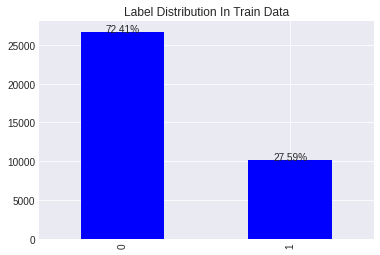

In [12]:
ax = data['Unusual'].value_counts().plot.bar(color = 'blue')
size = data.shape[0]
for p in ax.patches:
  height, width, x= p.get_height(), p.get_width(), p.get_x()
  percent = height/size * 100
  label = '{:,.2f}%'.format(percent)
  ax.annotate(label, (x + width*0.3, height))

plt.title('Label Distribution In Train Data')
plt.show()

**Observation**: The dataset is imbalance with 72.41% percent belonging to the negative class


#### CellName Column


In [13]:
data['CellName'].value_counts()

5ALTE     1157
4CLTE     1150
4ALTE     1147
8ALTE     1142
8CLTE     1137
6VLTE     1134
6ALTE     1134
4BLTE     1134
6WLTE     1133
5CLTE     1131
3CLTE     1131
6ULTE     1129
7BLTE     1128
1ALTE     1122
10ALTE    1121
7ULTE     1120
1CLTE     1120
8BLTE     1118
10CLTE    1117
3BLTE     1117
1BLTE     1117
7WLTE     1116
2ALTE     1116
9BLTE     1116
6BLTE     1112
3ALTE     1107
10BLTE    1107
5BLTE     1104
6CLTE     1102
9ALTE     1099
7CLTE     1096
7ALTE     1083
7VLTE     1007
Name: CellName, dtype: int64

**observation**: most of the observations where from 5ALTE cell though the observations is almost equally distributed across all cells.  

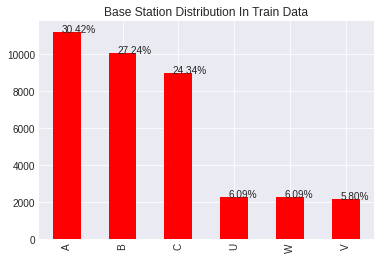

In [14]:
## extract the base name from the cell name and analyse the distribuion

data['BaseName'] = data['CellName'].map(lambda x : x[-4])
ax = data['BaseName'].value_counts().plot.bar(color = 'red')
size = data.shape[0]
for p in ax.patches:
  height, width, x= p.get_height(), p.get_width(), p.get_x()
  percent = height/size * 100
  label = '{:,.2f}%'.format(percent)
  ax.annotate(label, (x + width*0.3, height))

plt.title('Base Station Distribution In Train Data')
plt.show()

**observation** : The observations where mainly concentrated in base stations A, B, C  with just few percentages coming from U, W, V

#### maxUE_UL+DL

form the description provided, this should a numerical column but its provided as object type. Lets verify what is wrong 

In [15]:
data['maxUE_UL+DL'].value_counts()

5           5939
7           5322
8           3889
6           3883
9           3439
4           3391
10          2539
11          1899
3           1636
12          1388
2           1118
13           909
14           597
15           326
16           178
0            158
#¡VALOR!      84
17            82
18            41
19            31
1             28
20            18
23             2
21             2
Name: maxUE_UL+DL, dtype: int64

**observtion** : As seen there are points labelled as #¡VALOR!. Will take care of this during preprocessing.

See the data distribution in the float dtype columns. there are 10 of them

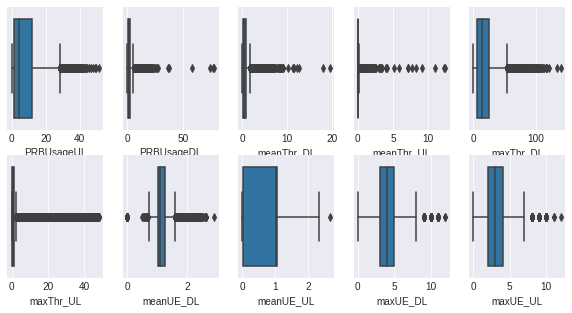

In [16]:
fl_columns = [col for col in data.columns if data[col].dtype == 'float64']
plt.figure(figsize= (10,5))
for i, col in enumerate(fl_columns):
  plt.subplot(2,5,i + 1)
  ax = sns.boxplot(x = col, data = data)

**Observation**: The numerical columns above contains outlier values. Though they wont affect my models as I would be using Tree-based models.

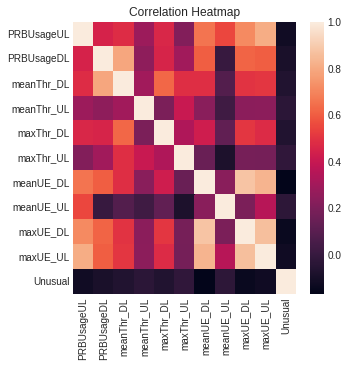

In [17]:
# plot the correation heatmap
plt.figure(figsize= (5,5))
sns.heatmap(data.corr())
plt.title('Correlation Heatmap')
plt.show()

### EDA Insights

1. maxUE_UL, maxUE_DL and maxUE_DL+UL all contains missing values. It was discovered that in most places where maxUE_UL/DL were none, the meanUE_UL/DL were also 0 and maxUE_DL+UL = #¡VALOR! if so the max values should also be zero. So the best imputation will be to fill nan values with zero.

2. The goal of the task to detect unusual situations and allocate resources appropriately. With the class imbalance, it will be nice if our model can actually detect a high percentage of this unusual situations in other to allocate the right resources(high recall) and also high precision in detecting the unusual class in other not to reconfigure the base_station when its not needed thereby leading to waste of resources. A good metric that maximizes this two is F1. 